## D. Heslop, J. L. Scealy, A. T. A. Wood, L. Tauxe and A. P. Roberts (2023). A bootstrap common mean direction test. Journal of Geophysical Research.
### Example estimation of bootstrap confidence region for a mean direction (see Section 2 of manuscript) using the normal polarity directions of MacFadden et al. (1990).

Please note that because this is a numerical procedure the results may differ slightly from those in the paper.

#### Import required libraries

In [1]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import numpy as np
import pandas as pd

-W- cartopy is not installed
    If you want to make maps, install using conda:
    conda install cartopy
-W- You haven't installed a module for plotting maps (cartopy or Basemap)
    Recommended: install cartopy.  With conda:
    conda install cartopy
    For more information, see http://earthref.org/PmagPy/Cookbook#getting_python


#### Function ```form_Mhat``` estimates $\hat{M}$ according to equation (4)

In [2]:
def form_Mhat(mhat):
    
    #input - mhat, estimated sample mean direction
    #output - Mhat matrix according to equation 4
    
    b = np.matrix(mhat[0:2][:,np.newaxis])
    c = mhat[2]
    
    if c==0:
        A1 = np.eye(2)-(b*b.getH())
    else:
        A1 = c/np.abs(c)*np.eye(2)-c/(np.abs(c)+np.abs(c)**2)*(b*b.getH())
        
    A2 = -b
    Mhat = np.hstack((A1,A2))
    return Mhat

#### Function ```form_Ghat``` estimates $\hat{G}$ according to equation (5)

In [3]:
def form_Ghat(X,Mhat):
    
    #input - X, collection of directions (one per column)
    #input - Mhat, Mhat matrix for mean direction
    #output - Ghat matrix according to equation 5

    n = np.shape(X)[1]
    term1 = np.power(np.linalg.norm(np.sum(X,axis=1)/n),-2)/n
    X = np.matrix(X)
    Mhat_T = Mhat.getT()
    Ghat = np.matrix(np.zeros((2,2)))
    
    for u in range(2):
        for v in range(2):
            for i in range(n):
                Ghat[u,v] += Mhat_T[:,u].getT()*X[:,i]*X[:,i].getT()*Mhat_T[:,v]
            Ghat[u,v] *= term1
    
    return Ghat

#### Function ```find_T``` estimates $T$ according to equation (6)

In [4]:
def find_T(m,n,Mhat,Ghat):
    
    #input - m, direction under consideration
    #input - n, number of observations
    #input - Mhat, Mhat matrix for mean direction
    #input - Ghat matrix representing covariance
    #output - T value estimated from Equation 6
    
    m = np.matrix(m[:,np.newaxis])
    
    return np.array(n*m.getT()*Mhat.getT()*np.linalg.inv(Ghat)*Mhat*m)    

#### Function ```find_CR``` calculates points along the boundary of the confidence region as described in Appendix A 

In [5]:
def find_CR(mhat,Mhat,Ghat,n,Tc):
    
    #input - mhat, mean direction of original data set
    #input - Mhat, Mhat matrix for mean direction
    #input - Ghat, matrix representing covariance
    #input - n, number of observations
    #input - Tc, critical T value on confidence region boundary
    #output - mCI, closed confidence region boundary
    
    C = n*Mhat.getT()*np.linalg.inv(Ghat)*Mhat
    [D,V] = np.linalg.eig(C)
    
    idx=np.flip(np.argsort(D))
    D = D[idx]
    V = V[:,idx]
    
    mCI = np.zeros((3,201))
    y = np.matrix(np.zeros((3,1)))
    for i in range(201):
            theta = i*np.pi/100
            y[0] = np.cos(theta)*np.sqrt(Tc)/np.sqrt(D[0])
            y[1] = np.sin(theta)*np.sqrt(Tc)/np.sqrt(D[1])
            y[2] = np.sqrt(1-y[0]**2-y[1]**2)
            mCI[:,i] = np.ndarray.flatten(V*y)
    
    mCIbar = np.mean(mCI,axis=1)/np.linalg.norm(np.mean(mCI,axis=1))
    if np.arctan2(np.linalg.norm(np.cross(mhat,mCIbar)),np.dot(mhat,mCIbar))>np.pi/2:
        mCI *= -1
        
    return mCI

#### Import the normal polarity directions from MacFadden et al. (1990) and transform to Cartesian coordinates (1 direction per column). 

#### Then estimate the mean direction via equation (3).

In [6]:
file = "MacFadden_normal.csv" #normal polarity directions of MacFadden et al. (1990)
DI = pd.read_csv(file,header=None).to_numpy()
X = np.transpose(pmag.dir2cart(DI))
n = np.shape(X)[1] #number of directions
mhat = np.mean(X,axis=1)
mhat /= np.linalg.norm(mhat) #estimate mean direction

### Main bootstrap sequence

In [7]:
B = 10000 #number of bootstrap iterations
T_b = np.zeros(B) #predefine output array for bootstrapped T values

for i in range(B): #loop through boostrap iterations
    idx = np.random.randint(0,n,n) #select observation indicies with replacement
    X_b = X[:,idx] #form bootstrap sample
    mhat_b = np.mean(X_b,axis=1) #mean direction of bootstrap sample
    mhat_b /= np.linalg.norm(mhat_b)
    Mhat_b = form_Mhat(mhat_b) #\hat{M} for bootstrap sample
    Ghat_b = form_Ghat(X_b,Mhat_b) #\hat{G} for bootstrap sample
    T_b[i] = find_T(mhat,n,Mhat_b,Ghat_b) #T for bootstrap sample
    
alpha = 0.05 #work with 95% confidence region
Tc = np.quantile(T_b,1-alpha) #find 1-alpha quantile of T
print("Critical T value = {:.2f}".format(Tc))

Critical T value = 8.32


#### Calculate the 95% confidence region

In [8]:
Mhat = form_Mhat(mhat)
Ghat = form_Ghat(X,Mhat)
Xc = find_CR(mhat,Mhat,Ghat,n,Tc) #calculate points along boundary of 95% confidence region
DIc = pmag.cart2dir(np.transpose(Xc)) #convert to dec and inc for plotting 

#### Plot the 95% confidence region (compare to manuscript Figure 2)

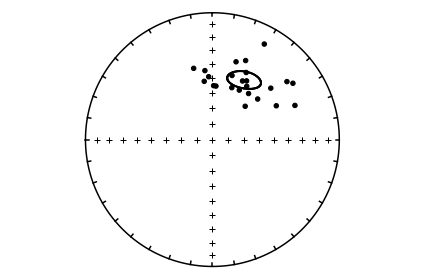

In [9]:
ipmag.plot_net(1)
ipmag.plot_di(dec=DI[:,0],inc=DI[:,1],color='black',edge='black')
ipmag.plot_di(di_block=DIc,color='black',edge='black',marker='.',markersize=4)

#### Test if any known point is inside 95% confidence region
If ```T0 < = Tc``` point is inside confidence region

If ```T0 > Tc``` point is outside confidence region

As an example case, choose a point on the 95% confidence region boundary and check that it returns ```Tc``` as calculated above.

In [10]:
T0 = find_T(Xc[:,0],n,Mhat,Ghat)
print("New point T value = {:.2f}".format(np.squeeze(T0)))

New point T value = 8.32
